# Introduction
* Notebook 6 already uses DNNs - both the multi-layer perceptron and Sequential from Keras are DNNs.
* Keras is focused on here since we can model our network architecture explicitly using it.
* In this example, Keras will learn on FX rates, but could be trained on any asset class and any features with the usual lags methodology
* This data is structured tick/intraday and contains {High, Low, Open, Close}

In [17]:
import random
import tensorflow.compat.v1 as tf
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import accuracy_score
tf.compat.v1.logging.set_verbosity('ERROR')
import numpy as np
import pandas as pd
from pylab import plt
plt.style.use('seaborn')
pd.set_option('precision', 4)
np.set_printoptions(suppress=True, precision=4)

In [2]:
url = 'http://hilpisch.com/aiif_eikon_id_eur_usd.csv'

In [3]:
symbol = 'EUR_USD'

In [4]:
raw = pd.read_csv(url, index_col=0, parse_dates=True)

In [5]:
raw.tail()

,HIGH,LOW,OPEN,CLOSE
Date,,,,
2019-12-31 22:11:00,1.1212,1.1211,1.1212,1.1211
2019-12-31 23:01:00,1.1212,1.1211,1.1211,1.1211
2019-12-31 23:03:00,1.1212,1.1211,1.1212,1.1211
2019-12-31 23:05:00,1.1212,1.1212,1.1212,1.1212
2019-12-31 23:06:00,1.1211,1.1211,1.1211,1.1211


In [6]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96526 entries, 2019-10-01 00:00:00 to 2019-12-31 23:06:00
Data columns (total 4 columns):
HIGH     96526 non-null float64
LOW      96526 non-null float64
OPEN     96526 non-null float64
CLOSE    96526 non-null float64
dtypes: float64(4)
memory usage: 3.7 MB


In [7]:
data = pd.DataFrame(raw['CLOSE'].loc[:])
data.columns = [symbol]
data.tail()

,EUR_USD
Date,
2019-12-31 22:11:00,1.1211
2019-12-31 23:01:00,1.1211
2019-12-31 23:03:00,1.1211
2019-12-31 23:05:00,1.1212
2019-12-31 23:06:00,1.1211


In [12]:
# Offset string list
data = data.resample('10min', label='right').last().ffill() # Fill NAs with previous populated value (Forward Fill)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13243 entries, 2019-10-01 00:50:00 to 2019-12-31 23:50:00
Freq: 10T
Data columns (total 1 columns):
EUR_USD    13243 non-null float64
dtypes: float64(1)
memory usage: 206.9 KB


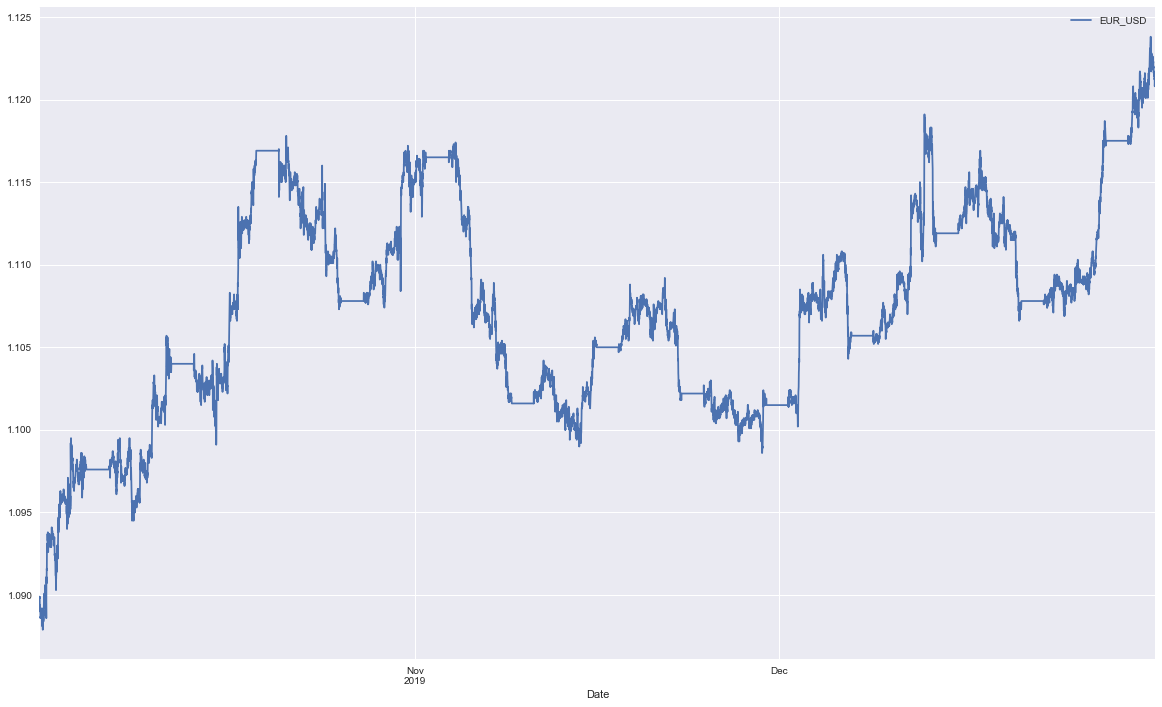

In [13]:
data.plot(figsize=(20,12))

In [14]:
# Now for the usual lags approach!
def add_lags(data, symbol, lags, window=50):
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    df['r'] = np.log(df / df.shift())
    df['sma'] = df[symbol].rolling(window).mean()
    df['min'] = df[symbol].rolling(window).min()
    df['max'] = df[symbol].rolling(window).max()
    df['mom'] = df['r'].rolling(window).mean()
    df['vol'] = df['r'].rolling(window).std()
    df.dropna(inplace=True)
    df['d'] = np.where(df['r'] > 0, 1, 0)
    features = [symbol, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']
    for f in features:
        for lag in range(1, lags+1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols

In [15]:
data, cols = add_lags(data, symbol, 5)

In [18]:
def set_seeds():
    random.seed(100)
    np.random.seed(100)
    tf.compat.v1.random.set_random_seed(100)

In [19]:
set_seeds()

In [20]:
optimizer = 'adam' # Default Keras optimizer

In [22]:
def create_model(hl=1, hu=128, optimizer=optimizer):
    model = Sequential()
    model.add(Dense(hu, # Input layer
                    input_dim=len(cols),
                   activation='relu'))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu')) # Hidden layers
    model.add(Dense(1, activation='sigmoid')) # Output Layer
    model.compile(loss='binary_crossentropy', # Loss function
                 optimizer=optimizer, # Optimizer Function
                 metrics=['accuracy']) # Other metrics to collect
    return model

In [25]:
set_seeds()
model = create_model(hl=1, hu=128)

In [26]:
%time model.fit(data[cols], data['d'], epochs=50, verbose=False)

CPU times: user 27.2 s, sys: 3.95 s, total: 31.1 s
Wall time: 18.3 s


In [27]:
model.evaluate(data[cols], data['d']) # Performance in sample - 70% accuracy!

413/413 [==============================] - 0s 975us/step - loss: 0.5408 - accuracy: 0.7037


[0.5407745242118835, 0.7037458419799805]

In [ ]:
split = int(len(data) * 0.8)
train = data.iloc(:split)
test = data.iloc(split:)